In [33]:
import os, sys, time, resource, re, gc, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from collections import Counter


import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import csv


import django

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from utils.text import *
from utils.utils import *

from parliament.models import *
from tmv_app.models import *
from twitter.models import *
from django.utils.dateparse import parse_datetime

sid = 13

In [5]:
sent_link = "http://pcai056.informatik.uni-leipzig.de/downloads/etc/SentiWS/SentiWS_v1.8c.zip"
sent_path = "../SentiWS/SentiWS_v1.8c_Negative.txt"

pars = Status.objects.filter(text__icontains="kohle",text__iregex='\w')

if not os.path.exists(sent_path):
    print("fetching data from sentiws")
    url = urlopen(sent_link)
    zipfile = ZipFile(BytesIO(url.read()))
    zipfile.extractall("SentiWS")
    print(zipfile.namelist())

fetching data from sentiws
['SentiWS.txt', '__MACOSX/', '__MACOSX/._SentiWS.txt', 'SentiWS_v1.8c_Negative.txt', '__MACOSX/._SentiWS_v1.8c_Negative.txt', 'SentiWS_v1.8c_Positive.txt', '__MACOSX/._SentiWS_v1.8c_Positive.txt']


In [14]:
from utils.text import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]

ttweets = set(Status.objects.filter(
    text__icontains="kohle"
).values_list('id',flat=True))

tids = random.sample(ttweets, 50000)

texts = Status.objects.filter(
    id__in=tids
).order_by('id').values_list('text',flat=True)


vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

dtf = vectorizer.fit_transform(texts)



/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gew'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


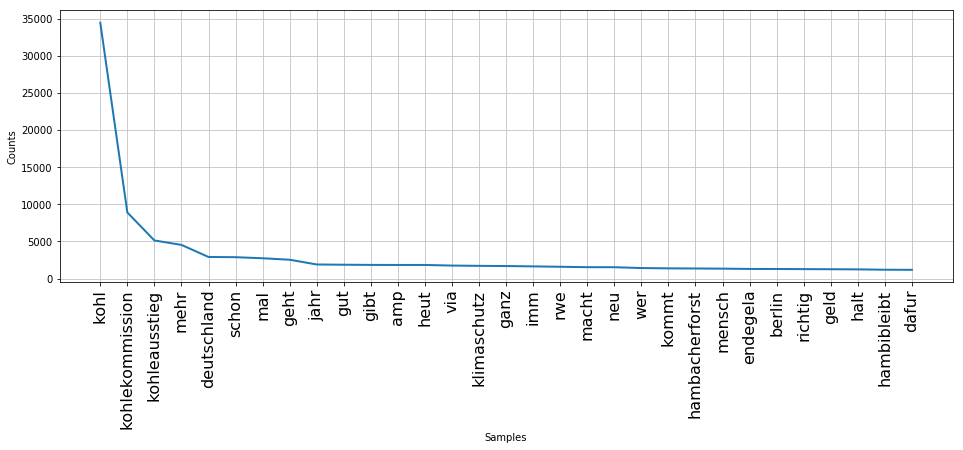

In [15]:
vocab = list(vectorizer.get_feature_names())
counts = dtf.sum(axis=0).A1
freq_dist = nltk.FreqDist(flatten([[x[0]]*x[1] for x in zip(vocab,counts)]))

plt.figure(figsize=(16,5))
plt.xticks(size=16)
freq_dist.plot(31)

In [16]:
import_words = False

if import_words:
    poswords = csv.reader(open('SentiWS/SentiWS_v1.8c_Positive.txt', 'r'), delimiter='\t')
    negwords = csv.reader(open('SentiWS/SentiWS_v1.8c_Negative.txt', 'r'), delimiter='\t')
    for i,row in enumerate(poswords):
        if len(row) > 2:
            ts = [row[0].split('|')[0]]+row[2].split(',')
        else:
            ts = [row[0].split('|')[0]]
        for t in ts:
            term, created = Term.objects.get_or_create(title=t.strip())
            tp, created = TermPolarity.objects.get_or_create(term=term,source="SentiWS")
            tp.polarity = float(row[1])
            tp.POS = row[0].split('|')[1].strip()
            tp.save()

    for i,row in enumerate(negwords):
        if len(row) > 2:
            ts = [row[0].split('|')[0]]+row[2].split(',')
        else:
            ts = [row[0].split('|')[0]]
        for t in ts:
            term, created = Term.objects.get_or_create(title=t.strip())
            tp, created = TermPolarity.objects.get_or_create(term=term,source="SentiWS")
            tp.polarity = float(row[1])
            tp.POS = row[0].split('|')[1].strip()
            tp.save()

In [17]:
pols = []
for v in vocab:
    try:
        p = TermPolarity.objects.get(term__title=v)
        pols.append(p.polarity)
    except:
        pols.append(0)
    

In [18]:
sentiment_scores = dtf*pols


In [19]:
sentiment_scores.shape

(50000,)

In [41]:
tweets = Status.objects.filter(
    id__in=tids
).order_by('id')

df = pd.DataFrame.from_dict({
    'text': texts,
    'sentiment': sentiment_scores,
    'party': [t.author.person.party.name if t.author.person else "none" for t in tweets],
    'color': [t.author.person.party.colour if t.author.person else "none" for t in tweets],
    'date': [t.created_at for t in tweets],
    #'month': [p.utterance.document.date.month if p.utterance.document.date is not None else None for p in pars ]
})

df.sort_values('sentiment').head()

,text,sentiment,party,color,date
20585,"@ReiseRobby @CheckAFD Aber nicht dumm, daß ist...",-2.0418,none,none,2018-08-22 10:54:49+00:00
8969,@Sarah15031 -&gt; scheiß fakeleute 😂😂 immer di...,-1.9541,none,none,2018-02-19 14:30:09+00:00
27185,"@focusonline Wer Häuser mit ""Glassplittern sic...",-1.7488,none,none,2018-10-21 06:43:22+00:00
9187,@greenpeace_de Freie Fahrt für #Diesel !! #Die...,-1.6930,none,none,2018-02-22 18:03:35+00:00
17411,"@hermesDE ja eben und das ist schlecht, dass S...",-1.6925,none,none,2018-07-09 14:43:15+00:00


In [22]:
df['text_length'] = df['text'].str.len() 
df['scaled_sentiment'] = df['sentiment'] / df['text_length']
df.sort_values('scaled_sentiment').head()

,text,sentiment,date,text_length,scaled_sentiment
6926,@vampir1n Die arme Shisha Kohle,-0.4546,2018-01-11 22:13:09+00:00,31,-0.014665
18692,@Naro5k Nicht schlecht 👌 is aber auch n Haufen...,-0.7706,2018-07-28 19:46:56+00:00,54,-0.014270
10738,@PuddingChanYo Same aber Kohle fehlt...,-0.5365,2018-03-25 17:33:30+00:00,39,-0.013756
177,"@Paradiesmaedchn ja, unfair! Der sitzt jetzt a...",-0.8827,2014-03-03 17:28:04+00:00,66,-0.013374
19184,"Knapp, aber: Keine Person wurde verletzt. #koh...",-0.7238,2018-08-04 14:46:44+00:00,56,-0.012925


In [24]:
min_length = 50
filt_df = df[(df['text_length'] > min_length)]
for i,p in filt_df.sort_values('sentiment').head().iterrows():
    print('\n#########')
    print(p['sentiment'])
    print(p['text'])


#########
-2.0418
@ReiseRobby @CheckAFD Aber nicht dumm, daß ist der Unterschied. 
Und die, die auch nicht ganz dumm sind bei denen, haben Kohle
und wollen mehr davon für sich und erzählen,  daß sie für die "Kleinen"
Leute sind. Die Dummen glauben das.

#########
-1.9540999999999997
@Sarah15031 -&gt; scheiß fakeleute 😂😂 immer diese Codes haben wollen und dann kein treffen möglich Hauptsache die ha en ihre Kohle 😂😂 wer's macht dumm Dümmer am dümmsten 👍 https://t.co/CBmMzu3kXe

#########
-1.7488000000000001
@focusonline Wer Häuser mit "Glassplittern sichert", legt ein hohes Maß an krimineller Energie an den Tag. Man nimmt in Kauf, dass sich Menschen verletzen.
(Ein krasser Widerspruch zu: "Leben statt Kohle.") In meinen Augen ist es daher falsch, diese Gruppierung als "Aktivisten" zu betiteln.

#########
-1.693
@greenpeace_de Freie Fahrt für #Diesel !! #Dieselfahrverbot  trifft wieder mal die sozial Schwachen. Wer Kohle kauft sich einfach eine neues Auto. Familien Rentner Alleinerziehen

In [26]:
for i,p in filt_df.sort_values('sentiment',ascending=False).head().iterrows():
    print('\n#########')
    print(p['sentiment'])
    print(p['text'])


#########
1.8436
Danke noch mal an alle die heute da zu beigetragen haben das das 1.Adventsgrillen ein tolles Event war. 
Danke der Kohle Manufaktur 
Danke Feuermeister 
Danke Joana-Bastard 
Danke Rösle 
Danke Broil King 
Danke unserem... https://t.co/cyRPOrlkkV

#########
1.8152
@Chris5Sh Leach wäre sicher extrem spannend. Glaube aber nicht, dass er sich das antut. Schätze ihn eher als Menschen ein, dem andere Dinge wichtiger sind als Kohle (die er in der NFL sicher mehr verdienen würde als bei WSU). Holgorsen oder Kingsbury fände ich spannend.

#########
1.8099
Nein, ich rege mich nicht auf.
Ich belächle lediglich all die Leute, die.. ach, egal.
Ich liebe mein Leben in meiner Lieblingsstadt, verdiene gut Kohle, hab nen wundervollen Kerl, ne tolle Mama, tolle Freunde und Bekannte..
keine Zeit für irgendeinen Bullshit.

#########
1.6306
Was ein sehr gutes Scouting ausmacht, zeigt Ajax Jahr für Jahr. Viele tolle Talente sichten und für absolut bezahlbares Geld verpflichten. Am Ende ver

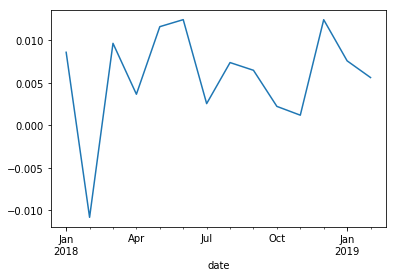

In [36]:
pdf = df[df['date'] > parse_datetime(f'2018-01-01T00:00:00+0000')]
months = pdf.set_index(pd.to_datetime(pdf['date']))
months.groupby(pd.Grouper(freq='M'))['sentiment'].mean().plot()

plt.show()

In [38]:
for name, group in months[months['date']>parse_datetime(f'2018-01-01T00:00:00+0000')].groupby(['party']):
    if name in ["cducsu","linke","spd","afd","gruene"]:     
        print(name)
        group.groupby(pd.Grouper(freq='M'))['sentiment'].mean().plot(color=group['colour'][0])
        #group['month'] = group['date'].month
        #group.groupby(['date'])['sentiment'].mean().plot()

#df.groupby(['date','party'])['sentiment'].mean().plot()

plt.show()

afd


KeyError: 'colour'

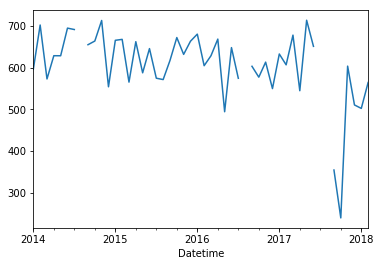

In [45]:
group['Datetime'] = pd.to_datetime(group['date'])
group = group.set_index(group['Datetime'])
#group = group.set_index(pd.DatetimeIndex(group['Datetime']))

group
group.groupby(pd.Grouper(freq='M'))['scaled_sentiment'].mean().plot()

plt.show()

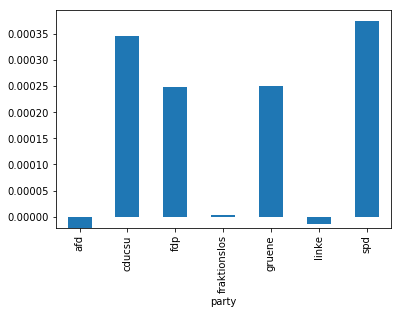

In [46]:
df.groupby('party')['scaled_sentiment'].mean().plot(kind='bar')

plt.show()

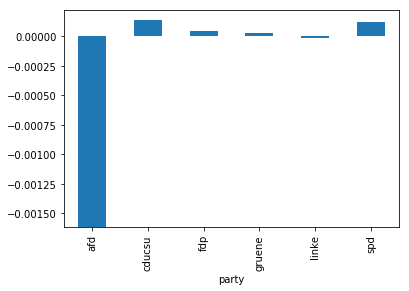

In [47]:
filt_df.groupby('party')['scaled_sentiment'].mean().plot(kind='bar')
plt.show()